### Visualizing the distribution of the observations

### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index= 'BSBSSSBB'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(10)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
13081
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     36.6| 31.9297| -82.6792|       TMAX|USC00095386|    14|[90 55 A0 56 38 5...|1946.0|BSBSSSBB|
|     36.6| 31.9297| -82.6792|       TMAX|USC00095386|     0|[B0 58 E0 55 B0 5...|1947.0|BSBSSSBB|
|     36.6| 31.9297| -82.6792|       TMAX|USC00095386|     1|[78 5B 98 5A A0 5...|1948.0|BSBSSSBB|
|     36.6| 31.9297| -82.6792|       TMAX|USC00095386|    32|[70 5A 98 5A 48 5...|1950.0|BSBSSSBB|
|     36.6| 31.9297| -82.6792|       TMAX|USC00095386|     7|[00 58 90 59 C8 5...|1951.0|BSBSSSBB|
|     36.6| 31.9297| -82.6792|       TMAX|USC00095386|     9|[D0 5B 14 5C 

### Select data for a particular station and measurement type

In [2]:
### Function to extract the values 
measures = ['TOBS', 'TMIN', 'TMAX', 'PRCP', 'SNOW', 'SNWD']
data = []
for i in measures:
    sqlContext.registerDataFrameAsTable(df,'weather')
    Query="SELECT station, vector FROM weather\n\tWHERE measurement='%s'"%(i)
    df1 = sqlContext.sql(Query)
    rows=df1.rdd.map(lambda row:[unpackArray(row['vector'],np.float16), row['station']]).collect()
    measure = pd.DataFrame(rows, columns=('vector', 'station'))
    data.append(measure)

In [3]:
for i in range(0,4):
    data[i]['Jan_%s' %measures[i]] = data[i]['vector'].apply(lambda x: np.nanmean(x[:31])/10)
    data[i]['Feb_%s' %measures[i]] = data[i]['vector'].apply(lambda x: np.nanmean(x[31:59])/10)
    data[i]['Mar_%s' %measures[i]] = data[i]['vector'].apply(lambda x: np.nanmean(x[59:90])/10)
    data[i]['Apr_%s' %measures[i]] = data[i]['vector'].apply(lambda x: np.nanmean(x[90:120])/10)
    data[i]['May_%s' %measures[i]] = data[i]['vector'].apply(lambda x: np.nanmean(x[120:151])/10)
    data[i]['Jun_%s' %measures[i]] = data[i]['vector'].apply(lambda x: np.nanmean(x[151:181])/10)
    data[i]['Jul_%s' %measures[i]] = data[i]['vector'].apply(lambda x: np.nanmean(x[181:212])/10)
    data[i]['Aug_%s' %measures[i]] = data[i]['vector'].apply(lambda x: np.nanmean(x[212:243])/10)
    data[i]['Sep_%s' %measures[i]] = data[i]['vector'].apply(lambda x: np.nanmean(x[243:273])/10)
    data[i]['Oct_%s' %measures[i]] = data[i]['vector'].apply(lambda x: np.nanmean(x[273:304])/10)
    data[i]['Nov_%s' %measures[i]] = data[i]['vector'].apply(lambda x: np.nanmean(x[304:334])/10)
    data[i]['Dec_%s' %measures[i]] = data[i]['vector'].apply(lambda x: np.nanmean(x[334:])/10)
    data[i] = data[i].groupby('station').mean()
for i in range(4,6):
    data[i]['Jan_%s' %measures[i]] = data[i]['vector'].apply(lambda x: np.nanmean(x[:31]))
    data[i]['Feb_%s' %measures[i]] = data[i]['vector'].apply(lambda x: np.nanmean(x[31:59]))
    data[i]['Mar_%s' %measures[i]] = data[i]['vector'].apply(lambda x: np.nanmean(x[59:90]))
    data[i]['Apr_%s' %measures[i]] = data[i]['vector'].apply(lambda x: np.nanmean(x[90:120]))
    data[i]['May_%s' %measures[i]] = data[i]['vector'].apply(lambda x: np.nanmean(x[120:151]))
    data[i]['Jun_%s' %measures[i]] = data[i]['vector'].apply(lambda x: np.nanmean(x[151:181]))
    data[i]['Jul_%s' %measures[i]] = data[i]['vector'].apply(lambda x: np.nanmean(x[181:212]))
    data[i]['Aug_%s' %measures[i]] = data[i]['vector'].apply(lambda x: np.nanmean(x[212:243]))
    data[i]['Sep_%s' %measures[i]] = data[i]['vector'].apply(lambda x: np.nanmean(x[243:273]))
    data[i]['Oct_%s' %measures[i]] = data[i]['vector'].apply(lambda x: np.nanmean(x[273:304]))
    data[i]['Nov_%s' %measures[i]] = data[i]['vector'].apply(lambda x: np.nanmean(x[304:334]))
    data[i]['Dec_%s' %measures[i]] = data[i]['vector'].apply(lambda x: np.nanmean(x[334:]))
    data[i] = data[i].groupby('station').mean()

/root/anaconda2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [4]:
print data[0].shape, data[1].shape, data[2].shape, data[3].shape, data[4].shape, data[5].shape

(55, 12) (70, 12) (71, 12) (106, 12) (67, 12) (64, 12)


In [5]:
data = pd.concat([data[0], data[1], data[2], data[3], data[4], data[5]], axis=1, join='inner')
print data.shape
data.head()

(48, 72)


,Jan_TOBS,Feb_TOBS,Mar_TOBS,Apr_TOBS,May_TOBS,Jun_TOBS,Jul_TOBS,Aug_TOBS,Sep_TOBS,Oct_TOBS,...,Mar_SNWD,Apr_SNWD,May_SNWD,Jun_SNWD,Jul_SNWD,Aug_SNWD,Sep_SNWD,Oct_SNWD,Nov_SNWD,Dec_SNWD
station,,,,,,,,,,,,,,,,,,,,,
USC00083470,11.749451,13.492875,16.407010,19.632770,23.447167,25.767667,26.186473,25.986318,24.406500,19.806926,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
USC00084393,14.871875,15.283125,20.502500,22.217500,25.016250,26.518750,26.856250,26.834375,26.001250,21.697500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
USC00084394,9.218574,10.757258,14.117843,17.545082,21.021107,23.830040,24.717339,24.651613,22.754234,18.013832,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
USC00084731,11.786526,13.197043,16.793750,19.820924,23.197390,25.489229,26.057527,25.836694,24.017420,19.772540,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
USC00085099,15.383789,17.510352,20.984863,24.562097,28.021680,29.344841,29.741992,29.423633,28.430078,24.830469,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028371


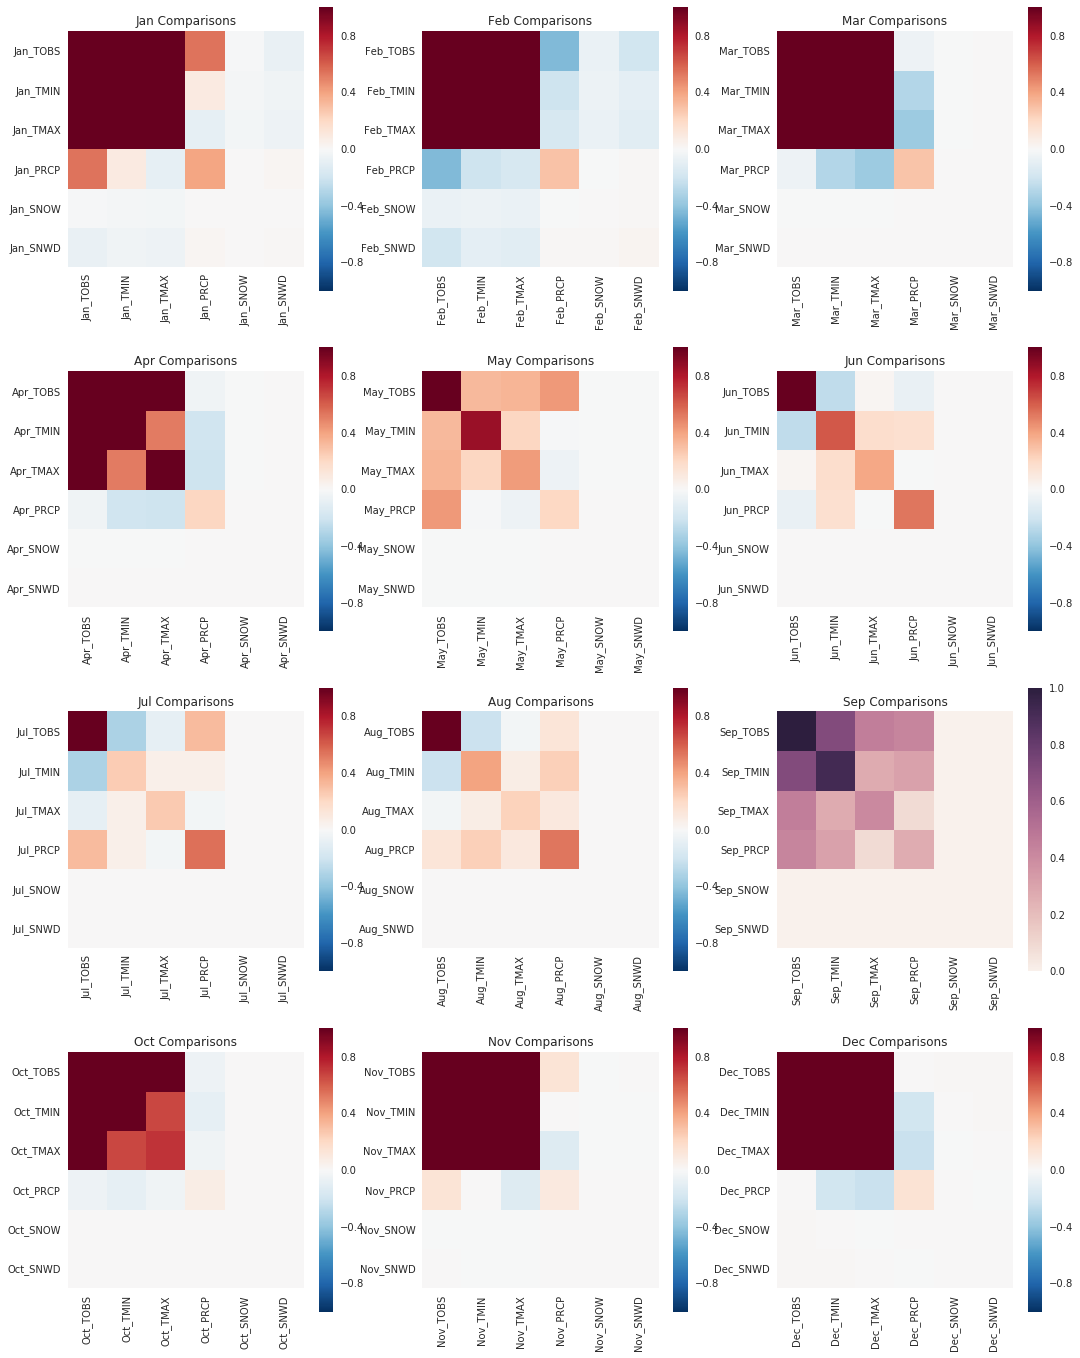

In [13]:
import seaborn as sns

num_plots = 12
fig, axes = plt.subplots(4,3,figsize=(18,24))

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for i in range(len(months)):
    a = data.filter(regex=months[i])
    mat = a.cov() # to get a heatmap of the covariance matrix
#     mat = a.corr() # to get a heatmap of the correlation matrix
    row = i // 3
    col = i % 3
    ax_curr = axes[row, col]
    sns.heatmap(mat, vmax=1, square = True, ax=ax_curr)
    ax_curr.set_title('%s Comparisons' %months[i])